In [23]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from sklearn.metrics import mean_absolute_percentage_error
from forecaster import Forecaster
import matplotlib.pyplot as plt
from prophet import Prophet
plt.style.use('default')

In [2]:
df = pd.read_csv('AAPL.csv', parse_dates = ['Date'])

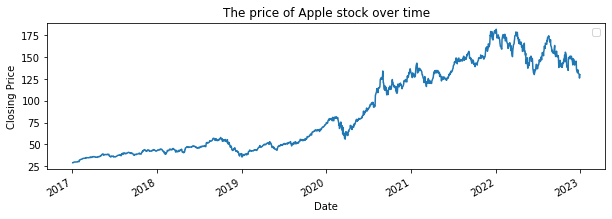

In [3]:
ax = df.plot(x='Date', y='Close', figsize = (10, 3))
ax.set_ylabel('Closing Price')
ax.set_title('The price of Apple stock over time')
ax.legend([])

In [4]:
df = df[['Date', 'Close']]

In [5]:
forecaster = Forecaster(
    df,
    x = 'Date',
    y = 'Close'
)

2023-09-05 13:40:07.394577: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-09-05 13:40:07.394622: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-05 13:40:07.394679: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (seshdesktop): /proc/driver/nvidia/version does not exist


,Training score,Test score
GRU,0.856179,0.141428


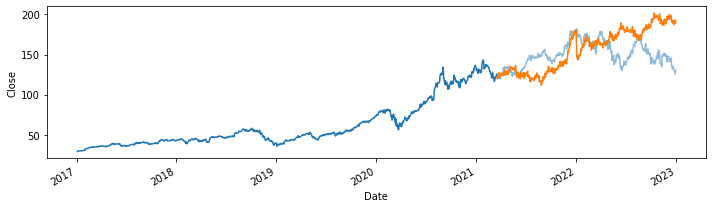

In [6]:
model = Sequential([
    GRU(units = 700),
    Dropout(0.1),
    Dense(units = 1)
], name = 'LSTM')

model.compile(optimizer = Adam(), loss = MeanSquaredError())
fit_kwargs = {'epochs': 30, 'batch_size': 32, 'verbose': 0}

pred, score = forecaster.validate(
    model, 
    seasonality = True, 
    #lag = np.arange(1, 60).tolist(),
    plot = True, 
    fit_kwargs = fit_kwargs
)

In [61]:
dates = df['Date'].unique()
n = len(dates)
split_date = dates[int(n*0.7)]

df_valid = df[df['Close'].notna()].set_index('Date')

y_valid = df_valid.loc[split_date:].sort_values(by = ['Date'])['Close'].copy()
y_train = df_valid.loc[:split_date]

14:02:03 - cmdstanpy - INFO - Chain [1] start processing
14:02:03 - cmdstanpy - INFO - Chain [1] done processing


Test error:  0.17898992373163009


<Axes: xlabel='Date'>

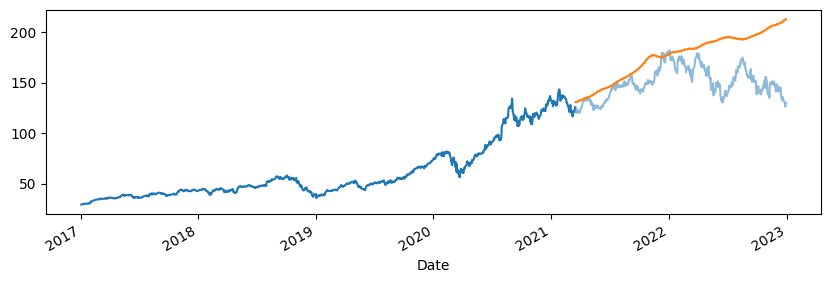

In [62]:
model = Prophet()
model.fit(y_train.reset_index().rename(columns = {'Date':'ds', 'Close':'y'}))
future = model.make_future_dataframe(len(y_valid), include_history = False)
y_pred = model.predict(future)['yhat']
print("Test error: ", mean_absolute_percentage_error(y_valid, y_pred))
y_pred = pd.Series(y_pred)
y_pred.index = y_valid.index
ax = X_valid['Close'].plot(figsize = (10, 3))
y_valid.plot(ax=ax, alpha = 0.5, color = 'tab:blue')
y_pred.plot(ax=ax, color = 'tab:orange')

Test error:  0.10641456701534613


<Axes: xlabel='Date'>

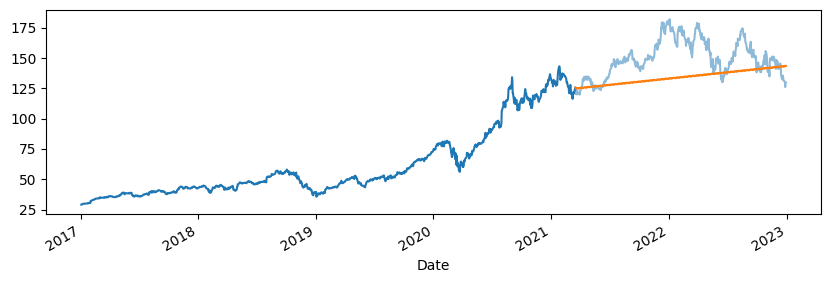

In [95]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.theta import ThetaForecaster

fh = ForecastingHorizon(y_valid.asfreq('D').interpolate().index, is_relative=False)
forecaster = ThetaForecaster(sp=12)
forecaster.fit(y_train['Close'].asfreq('D').interpolate())
y_pred = forecaster.predict(fh)

print("Test error: ", mean_absolute_percentage_error(y_valid.asfreq('D').interpolate(), y_pred))
y_pred = pd.Series(y_pred)
y_pred.index = y_valid.asfreq('D').interpolate().index
ax = X_valid['Close'].plot(figsize = (10, 3))
y_valid.plot(ax=ax, alpha = 0.5, color = 'tab:blue')
y_pred.plot(ax=ax, color = 'tab:orange')

In [70]:
from sktime.datasets import load_airline
load_airline()

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [80]:
y_t = y_train['Close']
y_t.Freq = 'D'

In [92]:
y_train['Close'].asfreq('D').interpolate()

Date
2017-01-03     29.037500
2017-01-04     29.004999
2017-01-05     29.152500
2017-01-06     29.477501
2017-01-07     29.567500
                 ...    
2021-03-13    122.016665
2021-03-14    123.003332
2021-03-15    123.989998
2021-03-16    125.570000
2021-03-17    124.760002
Freq: D, Length: 1535, dtype: float64

In [93]:
y_valid

Date
2021-03-17    124.760002
2021-03-18    120.529999
2021-03-19    119.989998
2021-03-22    123.389999
2021-03-23    122.540001
                 ...    
2022-12-23    131.860001
2022-12-27    130.029999
2022-12-28    126.040001
2022-12-29    129.610001
2022-12-30    129.929993
Name: Close, Length: 453, dtype: float64